# Use script by Jose to generate new TREECOOL files
(example by Keir Rogers)

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.cm as mcm
import scipy.special as sps
import gen_UVB as UVB

### Define reionization history for both Hydrogen and Helium, as a function of a couple of parameters

In [2]:
def volume_filling_factor_HII(z, z_mid, n_1=50., n_2=1.):
    """Simple parametric model for input volume filling factor of ionised hydrogen (Q_HII) as a function of redshift z"""
    sign_array = np.zeros_like(z) + (z <= z_mid) - (z > z_mid)
    gamma_a = np.zeros_like(z) + ((z <= z_mid) / n_1)  + ((z > z_mid) / n_2)
    gamma_x = np.zeros_like(z) + ((z <= z_mid) * (np.abs(z - z_mid) ** n_1))  + ((z > z_mid) * (np.abs(z - z_mid) ** n_2))
    return 0.5 + (0.5 * sign_array * sps.gammainc(gamma_a, gamma_x))

def volume_filling_factor_HeIII(z, z_end):
    """Simple parametric model for input volume filling factor of doubly-ionised helium (Q_HeIII) as a function of z"""
    arctan_model = 1. - np.arctan(z - z_end)
    arctan_model[arctan_model > 1.] = 1.
    arctan_model[arctan_model < 0.] = 0.
    return arctan_model

def find_z_end_HI_reion(z, z_mid, n_1=50., n_2=1.):
    """Approximate the redshift when HI reionisation has 'finished' (Q_HII = 1)"""
    return np.max(z[volume_filling_factor_HII(z, z_mid, n_1=n_1, n_2=n_2) == 1.])


In [3]:
## Input Variables
# listz: array with redshift (goes from low to high)
# QHII: value of QHII for listz
# z_HII: redshift when QHII=1.0
# QHeIII: value of QHeIII for listz
# z_HeIII: redshift when QHeIII=1.0
# DeltaT_HI: total heat injection due to HI reionization (Kelvin)
# DeltaT_HeII: total heat injection due to HeII reionization (Kelvin)
# model: indicates which photoionization and photoheating rates will be used once reionization is finished
# cosmoHM: [hubble,Omega_b,Omega_M,Omega_L,Xp] for example cosmoHM=[0.702,0.046,0.275,0.725,0.76]
# Gthreshold: true or false. True (default) does corrections to fix points near reionization redshift
# fout: name for the TREECOOL file, if None data is not saved in file

z_mid_HI_reion = 7.65 #10.8 #9.4
z_end_HeII_reion = 3.

DeltaT_HI = 2.e+4 #K
DeltaT_HeII = 1.5e+4 #K

model = 'P18' #'OHL16' #I think this should point to TREECOOL file (???) - get OHL16 file
omega_m = 0.31
cosmoHM = [0.67, 0.045, omega_m, 1. - omega_m, 1. - 0.2453] #X_P = 1 - Y_P (???)
# the new file will be stored here
fout = 'test_TREECOOL_O17.txt'

listz=np.arange(0.,18.,0.01)

#QHII = volume_filling_factor_HII(listz, z_mid_HI_reion)
QHII = UVB.myfQHII_2(listz,z_mid_HI_reion,n1=50.,n2=1.,norm=0.5)
z_HII = find_z_end_HI_reion(listz, z_mid_HI_reion)
print('z_end for HI reionisation model (Q_HII = 1) =', z_HII)

QHeIII = volume_filling_factor_HeIII(listz, z_end_HeII_reion)
z_HeIII = z_end_HeII_reion
print('z_end for HeII reionisation model (Q_HIII = 1) =', z_HeIII)


z_end for HI reionisation model (Q_HII = 1) = 6.58
z_end for HeII reionisation model (Q_HIII = 1) = 3.0


Text(0, 0.5, 'Volume filling factor (Q_HII, Q_HeIII)')

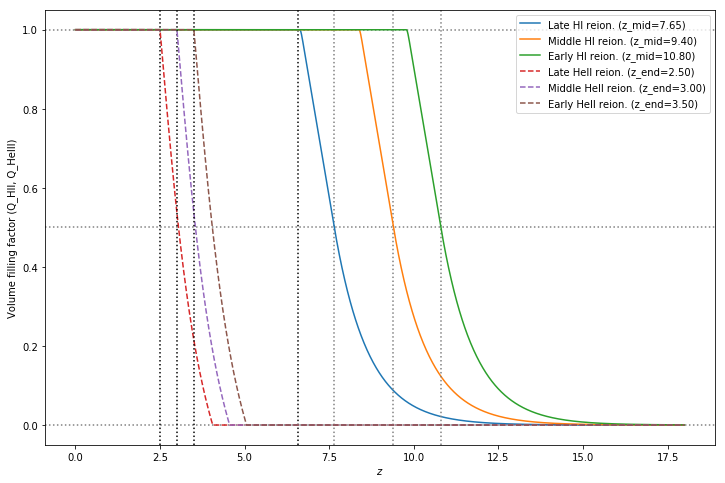

In [4]:
# define three reionization models
z_mid_examples_HI = np.array([7.65, 9.4, 10.8])
z_end_examples_HeII = np.array([2.5, 3., 3.5])
z_labels = np.array(['Late', 'Middle', 'Early'])

plt.figure(figsize=(12., 8.))

plt.axhline(y = 0., color='gray', ls=':')
plt.axhline(y = 0.5, color='gray', ls=':')
plt.axhline(y = 1., color='gray', ls=':')
plt.axvline(x = find_z_end_HI_reion(listz, z_mid_examples_HI[0]), color='black', ls=':')

for i in range(z_mid_examples_HI.size):
    plt.axvline(x = z_mid_examples_HI[i], color='gray', ls=':')
    #plt.plot(listz, volume_filling_factor_HII(listz, z_mid_examples_HI[i]), label='%s HI reion. (z_mid=%.2f)'%(z_labels[i], z_mid_examples_HI[i]))
    plt.plot(listz, UVB.myfQHII_2(listz,z_mid_examples_HI[i],n1=50.,n2=1.,norm=0.5), label='%s HI reion. (z_mid=%.2f)'%(z_labels[i], z_mid_examples_HI[i]))
for i in range(z_end_examples_HeII.size):
    plt.axvline(x = z_end_examples_HeII[i], color='black', ls=':')
    plt.plot(listz, volume_filling_factor_HeIII(listz, z_end_examples_HeII[i]), label='%s HeII reion. (z_end=%.2f)'%(z_labels[i], z_end_examples_HeII[i]), ls='--')

plt.legend()
plt.xlabel(r'$z$')
plt.ylabel(r'Volume filling factor (Q_HII, Q_HeIII)')

#print(volume_filling_factor_HII(listz, 8.) == 1.)


In [5]:
# generate new treecool file, and write to disk
zG,dataG=UVB.genQ2G_DeltaT(listz,QHII,z_HII,QHeIII,z_HeIII,DeltaT_HI,DeltaT_HeII,
                           model=model,cosmo=cosmoHM,Gthreshold=True,fout=fout)

TREECOOL file = /Users/font/Projects/LyaCosmoParams//setup_simulations/test_sim/TREECOOL_P18.txt


Text(0.5, 1.0, 'Solid = Onorbe+ 2017; dashed = TREECOOL_P18')

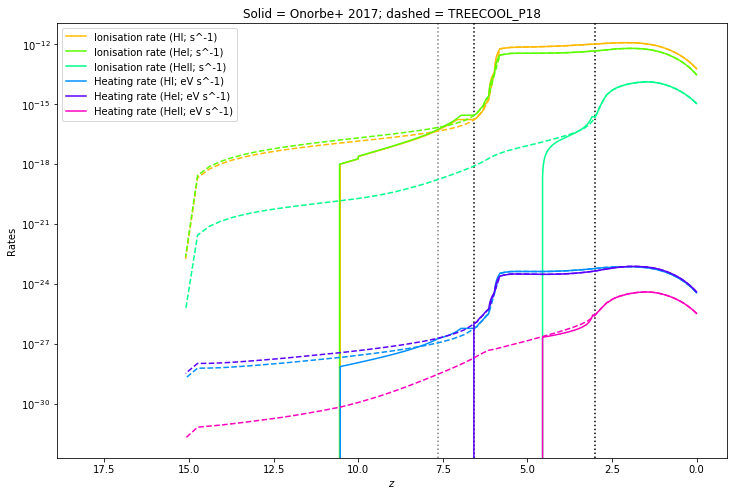

In [6]:
#Plot UVB rates
treecool_file=os.environ['LYA_EMU_REPO']+'/setup_simulations/test_sim/TREECOOL_P18.txt'
print('TREECOOL file =',treecool_file)
treecool_P18 = np.loadtxt(treecool_file)
treecool_O17 = np.loadtxt('test_TREECOOL_O17.txt')

rate_labels = [r'Ionisation rate (HI; s^-1)', r'Ionisation rate (HeI; s^-1)', r'Ionisation rate (HeII; s^-1)', r'Heating rate (HI; eV s^-1)', r'Heating rate (HeI; eV s^-1)', r'Heating rate (HeII; eV s^-1)']

plt.figure(figsize=(12., 8.))
plt.axvline(x=z_mid_HI_reion, color='gray', ls=':')
plt.axvline(x=z_HII, color='black', ls=':')
plt.axvline(x=z_end_HeII_reion, color='black', ls=':')

for i in range(1, treecool_P18.shape[1]):
    line_colour = mcm.gist_rainbow(i / (treecool_P18.shape[1] - 1))
    plt.plot((10. ** treecool_O17[:, 0]) - 1., treecool_O17[:, i], color=line_colour, label=rate_labels[i-1])
    plt.plot((10. ** treecool_P18[:, 0]) - 1., treecool_P18[:, i], color=line_colour, ls='--')

plt.gca().invert_xaxis()
plt.yscale('log')
plt.legend()
plt.xlabel(r'$z$')
plt.ylabel(r'Rates')
plt.title(r'Solid = Onorbe+ 2017; dashed = TREECOOL_P18')
